In [5]:
from savejupyterdata import load, save
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import statsmodels.api as sm

import os
import time
import re
import numba

from sklearn.decomposition import PCA
from sklearn.svm import SVR, LinearSVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import defaultdict

In [2]:
fd_pos = pd.read_csv('pos_definitions.csv')
fd_neg = pd.read_csv('neg_definitions.csv')
into_pos = pd.read_csv('pos_featureValues.csv')
into_neg = pd.read_csv('neg_featureValues.csv')


fd_pos.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)
fd_neg.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)
into_pos.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)
into_neg.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)

def remove_first_two_num(col):
    if re.match('^[0-9]{2}.*.mzXML', col):
        return col[2:-6].replace('_pos', '').replace('_neg', '')
    elif 'QC' in col:
        return col[:-6].replace('_pos', '').replace('_neg', '')
    else:
        return col.replace('_pos', '').replace('_neg', '')
    
into_pos.rename(columns=remove_first_two_num, inplace=True)
into_neg.rename(columns=remove_first_two_num, inplace=True)

In [6]:
class ChromatographData():
    """
    Objects contain data and transform method
    """
    def __init__(self, data, polarity='postive', feature_index_col='parse'):
        """
        :data: pd.DataFrame
        :polarity: 'positive' or 'negative'
        :feature_index_col: col identifier if there is
        """
        #self._polartity
        if not any([polarity.lower() in two for two in ['positive', 'negative']]):
            raise ValueError(f'invalid polarity parameter!{polarity}')
        if polarity.lower() in 'positive':
            self._polarity = 'Positive'
        else:
            self._polarity = 'Negative'
        
        #self._data and self._index
        if feature_index_col =='parse':
            self._index = data.loc[:, data.dtypes==np.object]
            if self._index.shape[1]>1:
                raise MoreThanOneIndexCol(
                    f'data has {self._index.shape[1]} object columns! (must be 1)')
            self._data = data.loc[:, data.dtypes!=np.object]
            
        elif isinstance(feature_index_col, int):
            self._index = pd.DataFrame(data.iloc[:, feature_index_col]).rename(
                columns={0:data.columns[feature_index_col]})
            self._data = data.loc[:, data.columns != data.columns[feature_index_col]]
        
        elif isinstance(feature_index_col, str):
            self._index = pd.DataFrame(data.loc[:, feature_index_col]).rename(
                columns={0:feature_index_col})
            self._data = data.loc[:, data.columns != feature_index_col]
            
        else:
            raise TypeError('feature_index_col must be "parse", int or str!')
        
        #get indices list about QCs, filters and test samples
        self._qc_indices, self._filter_indices, self._test_indices = self._get_index()
        self._categories, self._simple_columns = self._classify()      
        
    def __repr__(self):
        """
        print Data status
        include data shape, process history
        """
        return(f'''Chromatograph data:\n
        data shape {self._data.shape}''')
    
    def _get_index(self):
        qcs = []
        filters = []
        tests = []
        for i, col in enumerate(self._data.columns):
            if col.startswith('QC'):
                qcs.append(i)
            elif col.startswith('Fi'):
                filters.append(i)
            else:
                tests.append(i)
        return [pd.Index(indices) for indices in [qcs, filters, tests]]
    
    @property
    def df(self):
        return self._data
    
    def _classify(self):
        cates = defaultdict(list)
        simple_columns = []
        
        for i, col in enumerate(self._data.columns):
            if 'cond' in col:
                cates[col[:-1]].append(i)
                simple_columns.append(col[:-1])
            else:
                cates[re.match('(.*)_.*', col)[1]].append(i)
                simple_columns.append(re.match('(.*)_.*', col)[1])
                
        return cates, simple_columns
    
    def fill_na_by_categories(self):
        s = time.time()
        df = self.df
        cates, cols = [], []
        for c, r in self._categories.items():
            cates.append(c)
            cols.append(r)
        df_vals = df.values
        for cate, col in zip(cates, cols):
            data = df_vals[:, col]
            df_vals[:, col] = self._fill_fast(data)

        df_vals = self._fill_all(df_vals)
        df = pd.DataFrame(df_vals, index=self._data.index,
                         columns=self._data.columns)
        self._data = df
    
    @staticmethod
    @numba.njit
    def _fill_fast(data):
        for i in range(data.shape[0]):
            temp = data[i,:]
            med = np.nanmedian(temp)
            temp[np.isnan(temp)] = med
            data[i, :] = temp
        return data
    
    @staticmethod
    @numba.njit
    def _fill_all(data):
        for i in range(data.shape[0]):
            temp = data[i,:]
            minimum = np.nanmin(temp)/(3**.5)
            temp[np.isnan(temp)] = minimum
            data[i, :] = temp
        return data

    def get_df(self, cate):
        return self._data.iloc[:, self._categories[cate]]
    
    def balance_runtime(self, center, method='LinearSVR'):
        svr = LinearSVR(max_iter=10000000)
        rsd = self.RSD_QCs()
        indices=rsd[rsd<0.3].index.values
        qc = self._data.iloc[indices, self._qc_indices]
        
        center = self._data.iloc[indices, center][:,None]
        medians = (center/qc).median().values
        svr.fit(self._qc_indices.values.reshape(-1,1),
               medians)
        
        coefs = svr.predict(np.arange(self._data.shape[1]).reshape(-1, 1))
        self._data = self._data*coefs
    
    def filter_by_RSD(self, threshold=0.3):
        rsd = self.RSD_QCs()
        new_indices = rsd[rsd<threshold].index
        self._data = self._data.loc[new_indices,:]
        
    def RSD_QCs(self):
        qc = self.get_df('QC')
        return qc.std(1)/qc.mean(1)
    
    def agg_cates(self):
        res = []
        for cate, cols in self._categories.items():
            temp = self._data.iloc[:, cols].median(1)
            res.append(pd.DataFrame(temp, columns=[cate]))
        return pd.concat(res, axis=1).sort_index(axis=1)

In [7]:
pos = ChromatographData(into_pos, 'positive')

pos.fill_na_by_categories()

pos.balance_runtime(27)

pos.filter_by_RSD()

In [26]:
file_pos = pd.read_excel('/home/prz/movingdisk/cdResults/urine06012019/positive.xlsx')
file_neg = pd.read_excel('/home/prz/movingdisk/cdResults/urine06012019/negative.xlsx')

In [27]:
file_pos.head()

,Checked,Name,Formula,Annotation Source: Predicted Compositions,Annotation Source: mzCloud Search,Annotation Source: Metabolika Search,Annotation Source: ChemSpider Search,FISh Coverage,Molecular Weight,RT [min],...,Adj. P-value: (Filter) / (E),Adj. P-value: (F) / (E),Adj. P-value: (A) / (E),Adj. P-value: (D) / (E),Adj. P-value: (Filter) / (F),Adj. P-value: (A) / (F),Adj. P-value: (D) / (F),Adj. P-value: (Filter) / (A),Adj. P-value: (D) / (A),Adj. P-value: (Filter) / (D)
0,0.0,Creatinine,C4 H7 N3 O,Full match,Full match,No results,Partial match,NaN,113.059,0.81,...,1.0,1.0,0.004188,1.0,0.640363,0.001056,1.0,0.006223,0.005825,1.0
1,NaN,Checked,Molecular Weight,RT [min],FWHM [min],Max. # MI,# Adducts,Area,File ID,Study File ID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,False,113.059,0.825,0.062,1,3,1.01595e+09,114,F32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,Checked,Ion,Charge,Molecular Weight,m/z,RT [min],FWHM [min],# MI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,False,[M+H]+1,1,113.059,114.066,0.825,0.062,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
cp = file_pos.dropna(subset=['Checked'])
cn = file_neg.dropna(subset=['Checked'])

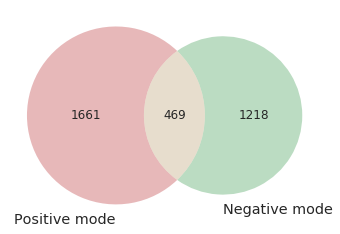

In [68]:
pnames, nnames = set(cp['Name'].unique()), set(cn['Name'].unique())
venn2([pnames, nnames], ('Positive mode', 'Negative mode'))

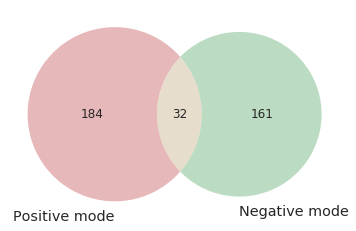

In [72]:
pnames = set(cp.loc[~np.isnan(cp['mzCloud Best Match']), 'Name'].unique())
nnames = set(cn.loc[~np.isnan(cn['mzCloud Best Match']), 'Name'].unique())
venn2([pnames, nnames], ('Positive mode', 'Negative mode'))

In [50]:
from matplotlib_venn import venn2

In [114]:
file_pos.iloc[1:233, 1::]

,Name,Formula,Annotation Source: Predicted Compositions,Annotation Source: mzCloud Search,Annotation Source: Metabolika Search,Annotation Source: ChemSpider Search,FISh Coverage,Molecular Weight,RT [min],Area (Max.),...,Adj. P-value: (Filter) / (E),Adj. P-value: (F) / (E),Adj. P-value: (A) / (E),Adj. P-value: (D) / (E),Adj. P-value: (Filter) / (F),Adj. P-value: (A) / (F),Adj. P-value: (D) / (F),Adj. P-value: (Filter) / (A),Adj. P-value: (D) / (A),Adj. P-value: (Filter) / (D)
1,Checked,Molecular Weight,RT [min],FWHM [min],Max. # MI,# Adducts,Area,File ID,Study File ID,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,False,113.059,0.825,0.062,1,3,1.01595e+09,114,F32,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Checked,Ion,Charge,Molecular Weight,m/z,RT [min],FWHM [min],# MI,Intensity,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,False,[M+H]+1,1,113.059,114.066,0.825,0.062,1,8.07682e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,False,[2M+H]+1,1,113.059,227.125,0.827,0.038,1,3.85516e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,False,[2M+K]+1,1,113.059,265.081,0.821,0.051,1,6.6373e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,False,113.059,0.82,0.05,1,3,8.48687e+08,64,F42,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Checked,Ion,Charge,Molecular Weight,m/z,RT [min],FWHM [min],# MI,Intensity,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,False,[M+H]+1,1,113.059,114.066,0.82,0.05,1,8.68451e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,False,[2M+H]+1,1,113.059,227.125,0.823,0.035,1,3.44448e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
before = 0
info = {}
for i, item in cp.iterrows():
    if i == 0:
        continue
    current = i
    feature_info = file_pos.iloc[before+1:current, 1:]
    info[cp.loc[i, 'Name']] = feature_info
    before = current

In [123]:
cp.shape

(9074, 119)

In [124]:
1661+469

2130

In [122]:
len(info)

2129

In [121]:
info[np.nan]

,Name,Formula,Annotation Source: Predicted Compositions,Annotation Source: mzCloud Search,Annotation Source: Metabolika Search,Annotation Source: ChemSpider Search,FISh Coverage,Molecular Weight,RT [min],Area (Max.),...,Adj. P-value: (Filter) / (E),Adj. P-value: (F) / (E),Adj. P-value: (A) / (E),Adj. P-value: (D) / (E),Adj. P-value: (Filter) / (F),Adj. P-value: (A) / (F),Adj. P-value: (D) / (F),Adj. P-value: (Filter) / (A),Adj. P-value: (D) / (A),Adj. P-value: (Filter) / (D)
491267,Checked,Molecular Weight,RT [min],FWHM [min],Max. # MI,# Adducts,Area,File ID,Study File ID,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491268,False,392.194,5.07,0.017,2,1,29852.6,70,F22,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491269,NaN,Checked,Ion,Charge,Molecular Weight,m/z,RT [min],FWHM [min],# MI,Intensity,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
491270,NaN,False,[M+H]+1,1,392.194,393.202,5.07,0.017,2,1.19938e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
